Project **Causal inference in multisensory perception**

__Adu Matory__ and __Lukas Braun__, March 1, 2020

In [1]:
!pip install emcee
!pip install corner

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import emcee
import corner

**1. Understand and implement the model**

**1b. In the following, the true visual and auditory stimuli positions are discrete
s v,a ∈ {−12, −6, 0, 6, 12} while the noisy stimuli x v,a and estimates ŝ v,a are contin-
uous. Use default parameters of p common = 0.8, σ v = 0.6, σ a = 3.1, σ p = 15, unless
instructed otherwise. Set μ p = 0 and leave it that way for all tasks.**

In [0]:
# 1b
# Initialise parameters
s_v = [-12, -6, 0, 6, 12]
s_a = [-12, -6, 0, 6, 12]

params = {
    "p_common": 0.8,
    "sigma_v": 0.6,
    "sigma_a": 3.1,
    "sigma_p": 15,
    "mu_p": 0
}

**1c. Write a function that implements Eq. 2 from the paper i.e. the probability of a
common cause given noisy stimuli p(C = 1|x v , x a ) and plot this probability as a
function of x v − x a (assume x a = 0). Vary p common , σ v , σ a , and σ p separately and
explain why the shape of the curve changes the way it does.**

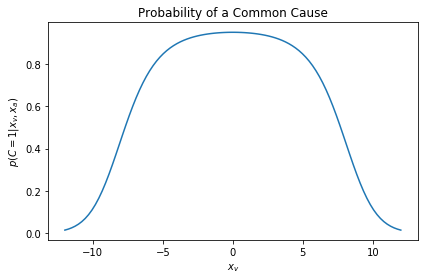

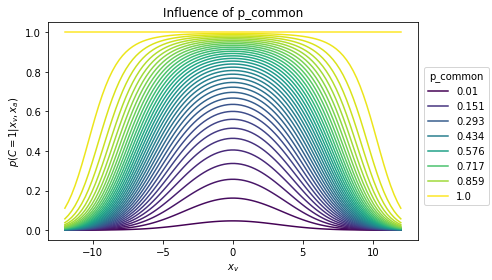

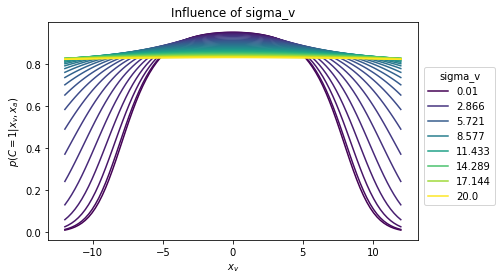

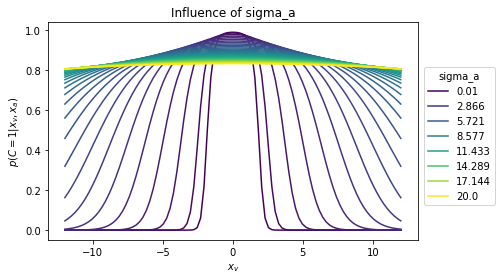

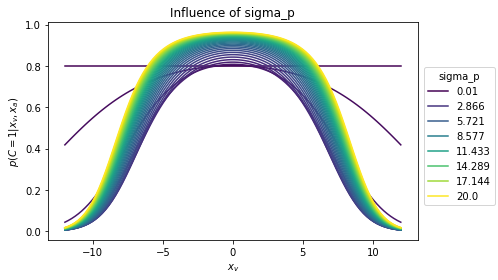

In [4]:
# 1c
def prob_common_cause(x_v, x_a, sigma_v, sigma_a, sigma_p,mu_p, p_common):
    """Equation 2 """
    # Calculate p(x_v, x_a | C=1)
    sigma_sum = sigma_v**2 * sigma_a**2 \
              + sigma_v**2 * sigma_p**2 \
              + sigma_a**2 * sigma_p**2
    prefactor = 1/(2*np.pi*np.sqrt(sigma_sum))
    nominator = (x_v-x_a)**2 * sigma_p**2 \
              + (x_v-mu_p)**2 * sigma_a**2 \
              + (x_a-mu_p)**2 * sigma_v**2
    p_xv_xa_c1 = prefactor * np.exp(-0.5*(nominator / sigma_sum))
    
    # Calculate p(x_v, x_a | C=2)
    sigma_sum_1 = sigma_v**2 + sigma_p**2
    sigma_sum_2 = sigma_a**2 + sigma_p**2
    prefactor = 1/(2*np.pi*np.sqrt(sigma_sum_1*sigma_sum_2))
    nominator_1 = (x_v-mu_p)**2
    nominator_2 = (x_a-mu_p)**2
    postfactor = np.exp(-0.5*((nominator_1 / sigma_sum_1) \
                            + (nominator_2 / sigma_sum_2)))
    p_xv_xa_c2 = prefactor * postfactor
    
    # Calculate p(C=1 | x_v, x_a)
    nominator = p_xv_xa_c1 * p_common
    denominator = p_xv_xa_c1 * p_common + p_xv_xa_c2 * (1-p_common)
    
    return nominator / denominator

# Plot probability of common cause for x_v - x_a with x_a = 0
x_v = np.linspace(-12, 12, 100)
prob = prob_common_cause(x_v, 0., **params)

fig, ax = plt.subplots()
ax.plot(x_v, prob)
ax.set_title("Probability of a Common Cause")
ax.set_xlabel("$x_v$")
ax.set_ylabel("$p(C=1 | x_v, x_a)$")
fig.tight_layout()

# Vary p_common, sigma_v, sigma_a, sigma_p
steps = 36
colors = plt.cm.viridis(np.linspace(0, 1, steps))

for key, (minimum, maximum) in [("p_common", (0.01, 1.)),
                                ("sigma_v", (0.01, 20.)),
                                ("sigma_a", (0.01, 20.)),
                                ("sigma_p", (0.01, 20.))]:
    params_ = params.copy()
    
    fig, ax = plt.subplots()
    for i, val in enumerate(np.linspace(minimum, maximum, steps)):
        params_[key] = val
        prob = prob_common_cause(x_v, 0., **params_)
        label_ = {"label": np.round(val, 3)} if i % 5 == 0 else {}
        ax.plot(x_v, prob, color=colors[i], **label_)
    ax.set_title(f"Influence of {key}")
    ax.set_xlabel("$x_v$")
    ax.set_ylabel("$p(C=1 | x_v, x_a)$")
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    fig.legend(loc='center left', bbox_to_anchor=(0.97, 0.5), title=key)
    fig.tight_layout()

**1d. Write functions that implement Eqs. 9 & 10, i.e. the estimated stimulus positions
ŝ v & ŝ a and plot both of the estimates as a function of x v assuming x a = 0. Once
again see what effect each model parameter has. Plot and explain your results.**

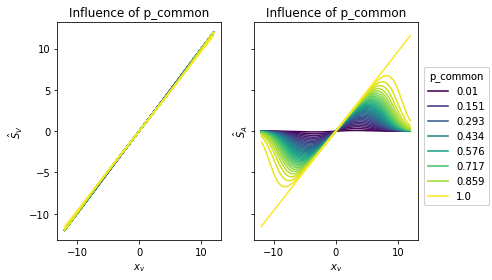

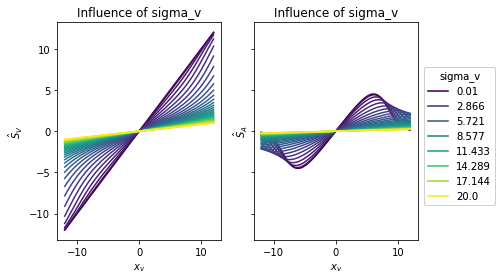

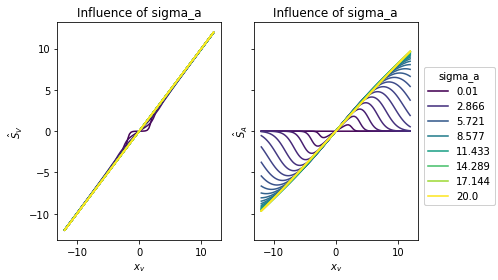

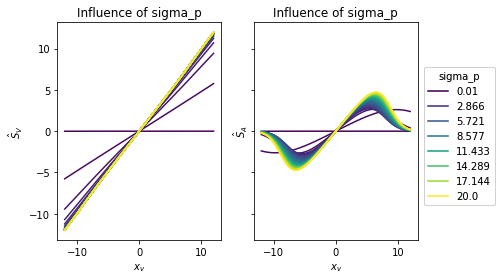

In [5]:
# 1d
def estimate_position(modality, x_v, x_a, sigma_v, sigma_a, sigma_p, mu_p, p_common):
    """Equations 9 & 10"""
    if modality == "V":
        s_hat_c2 = (x_v/sigma_v**2 + mu_p/sigma_p**2) / (1/sigma_v**2 + 1/sigma_p**2) # Equation 9
    elif modality == "A":
        s_hat_c2 = (x_a/sigma_a**2 + mu_p/sigma_p**2) / (1/sigma_a**2 + 1/sigma_p**2) # Equation 10
    
    s_hat_c1 = (x_v/sigma_v**2 + x_a/sigma_a**2 + mu_p/sigma_p**2) / (1/sigma_v**2 + 1/sigma_a**2 + 1/sigma_p**2)
    
    prob = prob_common_cause(x_v, x_a, sigma_v, sigma_a, sigma_p, mu_p, p_common)
    
    return prob*s_hat_c1 + (1-prob)*s_hat_c2


# Vary p_common, sigma_v, sigma_a, sigma_p
steps = 36
colors = plt.cm.viridis(np.linspace(0, 1, steps))

for key, (minimum, maximum) in [("p_common", (0.01, 1.)),
                                    ("sigma_v", (0.01, 20.)),
                                    ("sigma_a", (0.01, 20.)),
                                    ("sigma_p", (0.01, 20.))]:

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
    
    for i, modality in enumerate(["V", "A"]):
        params_ = params.copy()

        for n, val in enumerate(np.linspace(minimum, maximum, steps)):
            params_[key] = val
            prob = estimate_position(modality, x_v, 0., **params_)
            label_ = {"label": np.round(val, 3)} if n % 5 == 0 and modality == "V" else {}
            axs[i].plot(x_v, prob, color=colors[n], **label_)
        axs[i].set_title(f"Influence of {key}")
        axs[i].set_xlabel("$x_v$")
        axs[i].set_ylabel("$\\hat{S}_"+modality+"$")

        box = axs[i].get_position()
        axs[i].set_position([box.x0, box.y0, box.width * 0.9, box.height])
        fig.legend(loc='center left', bbox_to_anchor=(0.97, 0.5), title=key)
        fig.tight_layout()

**1e. Consider the integral in Equation 13, how might you evaluate it? Within the
integral appears p(^svjxv; xa): What kind of function is this? How does it aect the
analytic evaluation of the integral?**

The predicted distribution of visual positions is a gaussian, and therefore the integral can be parameterized nicely.

**1f. The nature of p(^svjxv; xa) also suggests a numerical method for obtaining estimates
of p(^sajsv; sa) and p(^svjsv; sa). Use that method to plot both as a function of sv
assuming sa = 0 (use a heat-map for these plots).**

In [0]:
# TODO: numerical methods for p(s_hat|s_v, s_a)


**2. Fit the computer model to experimental data**

**2a. To begin testing the generative model, we first need a method to produce an ob-
jective set of N stimulus pairs (s v , s a ). You can follow the procedure described in
the first paragraph of the Generative Model section of the paper, but there is also
a much simpler method. Hint: The objective stimuli have some fixed value for
p common and σ p , but those are not the same as the values used by the generative
model, and their values need not be known.**

In [0]:
# 2a
def generate_objective_set(N, sigma_p, p_common):
    objective_set = np.zeros((N, 2))
    cs = np.random.binomial(1, p_common, N)+1
    objective_set[cs==1, :] = np.random.normal(0, sigma_p, (np.sum(cs==1), 1))
    objective_set[cs==2, :] = np.random.normal(0, sigma_p, (np.sum(cs==2), 1))
    return objective_set

**2b. Write a function make button presses that
takes the number of trials N and parameters for the generative model and produces
a histogram of button presses for every possible stimulus pair (sv; sa).**

In [0]:
# 2b
def make_button_presses(N, sigma_v, sigma_a, sigma_p, mu_p, p_common):
    N = int(N)
    start = time.time()
    objective_set = generate_objective_set(N, sigma_p, p_common)
    s_hat = np.zeros((N, 2))
    s_hat[:, 0] = np.random.normal(objective_set[:, 0], sigma_v)
    s_hat[:, 1] = np.random.normal(objective_set[:, 1], sigma_a)
    
    bins = np.array([-np.inf, -9, -3, 3, 9, np.inf])
    hist, _ = np.histogramdd(s_hat, [bins, bins]) 
    return hist 

**2c. Using that function, generate button presses for N = 10 4 trials. This will be your
”experimental data”. An efficient implementation of this function should run in
≤ 50 ms for 10 5 trials.**

In [8]:
# 2c
%%time
N = 1e4
exp_data = make_button_presses(N, **params)

CPU times: user 5.16 ms, sys: 228 µs, total: 5.39 ms
Wall time: 5.1 ms


**2d. Write a function that computes the log-likelihood
(Eq. 16) of a model whose parameters are passed as arguments (Hint: you can
re-use make button presses within this new function). Use 10 times as many trials
as there are in the experimental data. Why is this important?**

A: It's important that we have a sample distribution closer to the actual probability distribution for MLE calculation.

In [0]:
# 2d
def log_likelihood(exp_data, params, eps=0):

  """ From model parameters, figure out how likely it is exp_data originated from this model.

  exp_data: the experimental data we wish to find the best-fit parameters for
  N: number of trials used to calculated the p_i for the considered model
  p_i: numerical approximations to the probabilities of each response in a given condition (sV, sA), produced by each model 
  n_i : probability of observing counts {ni}
  """
  try:
    model_hist = make_button_presses(exp_data.sum()*10, **params) # probabilities through many trials
  except TypeError:
    params['mu_p'] = 0
    model_hist = make_button_presses(exp_data.sum()*10, **params) # probabilities through many trials

  loglik = np.zeros(2) # one for s_v, one for s_a

  n_a = np.sum(exp_data, axis=0) # observed response counts, per auditory condition
  n_v = np.sum(exp_data, axis=1) # ... and visual condition
  
  p_a = np.sum(model_hist, axis=0)/np.sum(model_hist) # probability of button press for each auditory bin
  p_v = np.sum(model_hist, axis=1)/np.sum(model_hist) # and for visual bins

  loglik[0] = (n_a * np.log(p_a + eps)).sum() # log likelihood for sigma_a
  loglik[1] = (n_v * np.log(p_v + eps)).sum() # log likelihood for sigma_v


  return loglik.sum() # returns log likelihood of parameters fitting data

**2e. Test this new function using a set of parameters dierent from those used to generate
the experimental data. Look at numerical aspects, e.g. NaN & Infty. Why do they
appear in the calculation of the likelihood? What does this tell you about the shape
of the likelihood manifold in the parameter space? Does this have implications for
using gradient-based approaches to t the model? Consider adding a tiny epsilon to pi in
Eq. 16. What effect does this have and why is this desirable?**

A: NaN and infinity appears in the calculation of the likelihood because log(0) is undefined. This tells us that the likelihood manifold is convex in parameter space and has a global minimim, therefore we can use gradient-based sampling methods to search for parameters with maximum likelihood of fitting the data. Adding a small epsilon ensures that the logarithm doesn't return -infinity for zero or near-zero probabilities.

In [10]:
# 2e
params_2e = {
    "p_common": 0.9,
    "sigma_v": 2,
    "sigma_a": 1.2,
    "sigma_p": 10,
    "mu_p": 0
}

log_likelihood(exp_data, params_2e, eps=0)

-32608.821817478893

In [11]:
log_likelihood(exp_data, params_2e, eps=1e-10)

-32537.747830826538

**2f.We will now attempt a nave approach to t the generative model to the experimental
data. Compute the log-likelihood for all models within a reasonable parameter
space (0  pcommon  1, 0 < v;a;p < 20). Sample the parameter space at least 10
times per axis, yielding  104 models to test. Find the global maximum likelihood
value for the parameters. Given the particular values that you tested, and the true
values, did you nd the best possible estimate? Plot the marginal likelihoods with
respect to each parameter, and indicate the global max-likelihood values. Would
it have been possible to identify those maximum values using only the marginals?
Explain why.**

In [0]:
# 2f
param_sample = 10 # changing to <10 to save time while actively writing scripts

reasonable_param_range = {"p_common":[0.0,1.0],
                          "sigma_v": [0,20],
                          "sigma_a": [0,20],
                          "sigma_p": [0,20],
                          "mu_p": [0,0]
                          }

def make_param_combos(p_lim, samples):
  # parameter sampling in given ranges for p_common, sigma_v, sigma_a, and sigma_p 

  # # random sampling
  # pc = np.random.randint(p_lim['p_common'][0], p_lim['p_common'][1] + 1e10, samples)/1e10 
  # sv = np.random.uniform(p_lim['sigma_v'][0] + 1e-10, p_lim['sigma_v'][1] - 1e-10, samples)
  # sa = np.random.uniform(p_lim['sigma_a'][0] + 1e-10, p_lim['sigma_a'][1] - 1e-10,samples)
  # sp = np.random.uniform(p_lim['sigma_p'][0]+ 1e-10, p_lim['sigma_p'][1] - 1e-10,samples)

  # sampling over whole space
  pc = np.linspace(p_lim['p_common'][0], p_lim['p_common'][1], samples)/1e10 
  sv = np.linspace(p_lim['sigma_v'][0] + 1e-10, p_lim['sigma_v'][1] - 1e-10, samples)
  sa = np.linspace(p_lim['sigma_a'][0] + 1e-10, p_lim['sigma_a'][1] - 1e-10,samples)
  sp = np.linspace(p_lim['sigma_p'][0]+ 1e-10, p_lim['sigma_p'][1] - 1e-10,samples)  

  # sorting for easy plotting later
  sp.sort(), sa.sort(), sv.sort(), pc.sort()

  params_2f = [pc, sv, sa, sp]
  param_combos = np.array(list(itertools.product(pc, sv, sa, sp)))

  return pc, sv, sa, sp, params_2f, param_combos



In [0]:
pc, sv, sa, sp, params_2f, param_combos = make_param_combos(reasonable_param_range, param_sample)

In [0]:
# Calculating log likelihood for all models BRUTE FORCE
ll_2f = []
for i, x in enumerate(param_combos):

  ll_2f.append(log_likelihood(exp_data, {
      "p_common": x[0],
      "sigma_v": x[1],
      "sigma_a": x[2],
      "sigma_p": x[3],
      "mu_p": 0
      }, eps=1e-8))

ll_2f = np.array(ll_2f)

In [15]:
global_ml = param_combos[np.argmax(ll_2f)]
params_dif = np.array(list(params.values())[:-1]) - np.array(list(global_ml))

print(f'Difference between true parameters and maximum likelihood parameters... \
\n p_common: {params_dif[0]} \n sigma_v: {params_dif[1]} \n sigma_a: {params_dif[2]} \
\n sigma_p: {params_dif[3]} ')

Difference between true parameters and maximum likelihood parameters... 
 p_common: 0.7999999999777778 
 sigma_v: -6.0666666667000015 
 sigma_a: -3.566666666700001 
 sigma_p: 1.6666666666999976 


In [0]:
pc_marg = np.zeros(param_sample)# allocating for marginalized maximum likelihood estimations
sv_marg = np.zeros(param_sample)
sa_marg = np.zeros(param_sample)
sp_marg = np.zeros(param_sample) 

# Calculating marginal likelihoods for each parameter
for i in range(param_sample):
  pc_i = np.where(param_combos[:,0] == pc[i])[0]
  sv_i = np.where(param_combos[:,1] == sv[i])[0]
  sa_i = np.where(param_combos[:,2] == sa[i])[0]
  sp_i = np.where(param_combos[:,3] == sp[i])[0]

  pc_marg[i] = ll_2f[pc_i].mean()
  sv_marg[i] = ll_2f[sv_i].mean()
  sa_marg[i] = ll_2f[sa_i].mean()
  sp_marg[i] = ll_2f[sp_i].mean()


marginals = [pc_marg, sv_marg, sa_marg, sp_marg]

p_common: 1e-10 (marginal) vs. 2.222e-11 (global max)
sigma_v: 20.0 (marginal) vs. 6.667 (global max)
sigma_a: 20.0 (marginal) vs. 6.667 (global max)
sigma_p: 20.0 (marginal) vs. 13.33 (global max)


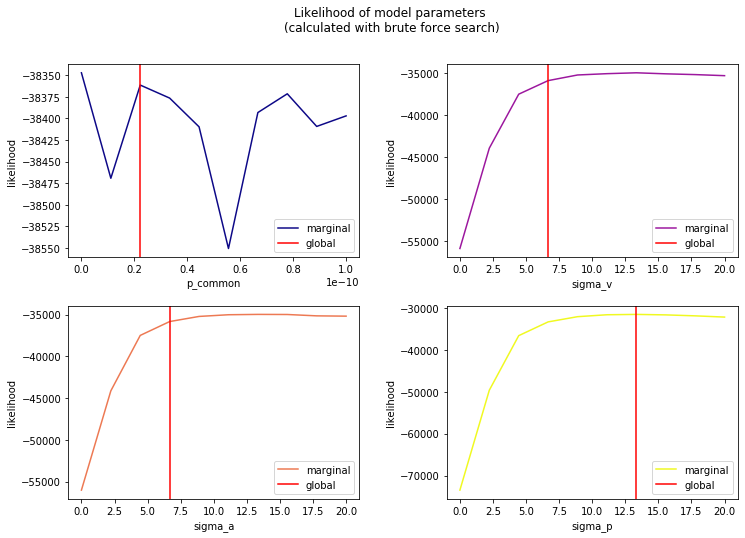

In [17]:
# Plotting parameter marginal likelihoods
fig, axs = plt.subplots(2,2, figsize=(12,8))
plt.subplots_adjust(hspace=.25,wspace=.3)
axs = axs.ravel()

colors = plt.cm.plasma(np.linspace(0, 1, len(marginals)))

plt.suptitle('Likelihood of model parameters \n(calculated with brute force search)')
for i, marg in enumerate(marginals):
  axs[i].plot(params_2f[i], marg, c=colors[i], label='marginal')
  axs[i].axvline(global_ml[i], label='global', c='r')
  axs[i].set_ylabel('likelihood')
  axs[i].set_xlabel(f'{list(params.keys())[i]}')
  axs[i].legend()
  print(f'{list(params.keys())[i]}: {np.max(params_2f[i]):.4} (marginal) vs. {global_ml[i]:.4} (global max)')


It would not have been possible to find the maximum values with only the marginals because the interaction priors between the terms dictate that the global maximum likelihood parameters must be derived from a combination of terms rather than the marginal maximum likelihood values.

**2g. Having completed a brute force search of the parameter space, let's now try something
a bit smarter: Use MCMC sampling (using the Ane Invariant method provided
in the package emcee) to estimate the posterior probability distribution of the
parameters. You will need to implement a function to calculate the log-probability;
it will call the log-likelihood function you implemented as well as a log-prior function
(use a rectangular prior that is nite for some reasonable parameter range).
Plot a corner plot of the result using the package corner.**

In [0]:
# def log_prior(priors, eps=1e-8):
#     """ Takes array of priors and returns their logarithm"""
#     return np.log(priors+eps)

# def box_function(priors, poi_limits):
#   """" Calculates a box function over the reasonable parameters, where  a rectangular 
#   prior, equal to 1 in the parameter range of interest and 0 elsewhere
  
#   prior: a dictionary of parameters and their values
#   poi_limits: a (ndim x 2) array of the limits for our parameters' ranges of interest.

#   Return: a (ndim x nwalker) binary array
#   """ 
#   box_prior = np.zeros(len(priors))

#   for i, param in enumerate(poi_limits.keys()):
#     llim = poi_limits[param][0] # lower limit
#     ulim = poi_limits[param][1] # upper limit

#     # setting parameters of interest to 1
#     if llim<priors[param] and priors[param]<ulim:
#         box_prior[i] = 1 

#   return box_prior

# def log_prob(p0_i, exp_data, poi_limits, eps=1e-8): 
#     ''' Calls the log-likelihood function as well as a log-prior function to 
#     generate a finite rectangular prior.

#     p0_i: an (ndim x 1) array of priors of a set of parameters
#     poi_limits: a (ndim x 2) array of the limits for our parameters' ranges of interest.
#     eps: ?regularization term for log calculation

#     Return: log probability (aka log posterior) of those prior '''
#     p0_i = {key: value for key, value in zip(params.keys(), p0_i)}
#     # p0_i['mu_p'] = 0 # settign constant parameter

    
#     log_lik = log_likelihood(exp_data, p0_i, eps) # calculating likelihood

#     box_p0_i = box_function(p0_i, poi_limits) # calculating box prior
#     print(box_p0_i)
#     print(list(p0_i.values()) * box_p0_i)

#     # calculating log posterior (aka log probability)
#     # print(box_p0_i, log_lik)
#     log_posterior = log_lik * log_prior(box_p0_i, eps)

#     return log_posterior

In [0]:

def log_prob(p0_i, exp_data, poi_limits, eps=1e-8): 
    ''' Calls the log-likelihood function as well as a log-prior function to 
    generate a finite rectangular prior.

    p0_i: an (ndim x 1) array of priors of a set of parameters
    poi_limits: a (ndim x 2) array of the limits for our parameters' ranges of interest.
    eps: ?regularization term for log calculation

    Return: log probability (aka log posterior) of those prior '''
    p0_i = {key: value for key, value in zip(params.keys(), p0_i)}
    # p0_i['mu_p'] = 0 # settign constant parameter

    within_range = True 
    for i,x in enumerate(list(p0_i.keys())): 
      if poi_limits[x][0] < list(p0_i.values())[i] < poi_limits[x][1]:
        continue
      else:
        within_range = False
        break

    if within_range: # box prior applied implicitly
      return log_likelihood(exp_data, p0_i, eps) # calculating likelihood
    else:
      return -np.inf

In [0]:
ndim = 4
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)*[1,20,20,20]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[exp_data, reasonable_param_range])
state = sampler.run_mcmc(p0, 30) 
sampler.reset()

In [21]:
sampler.run_mcmc(state, 1000)

State([[ 0.97934833 10.04845865 10.60115459 11.29152403]
 [ 0.1383839   5.14395291  5.69101391 14.22997682]
 [ 0.78753696 13.70047839 13.92105868  6.47935138]
 [ 0.32974304  4.47967249  2.93518994 14.87158953]
 [ 0.07206068 11.25485046 11.0858622  10.3436613 ]
 [ 0.30346885  9.44513064  9.55350237 11.64472658]
 [ 0.2456473   3.10977268  1.9491963  14.63264995]
 [ 0.72632505  8.23835025  8.3735308  12.6958772 ]
 [ 0.97488375  0.01809607  3.37746417 14.84376133]
 [ 0.61318918  5.6484488   7.23164663 13.74596172]
 [ 0.77025159 12.24243866 12.908       8.73051988]
 [ 0.78597418 14.48983065 14.3616085   4.15215103]
 [ 0.74416668  5.65850183  5.66587163 14.23945892]
 [ 0.78867487  1.24902997  2.97105586 14.93881856]
 [ 0.97440267 14.49401024 14.72046112  3.62749878]
 [ 0.38090114  3.41863418  4.03300281 14.84490338]
 [ 0.02716189  3.30572481  4.73589785 14.55716377]
 [ 0.60835512 10.24639836 11.05252946 10.65684698]
 [ 0.92560952 14.8950511  15.55701668  0.47218571]
 [ 0.64915356 11.60346153

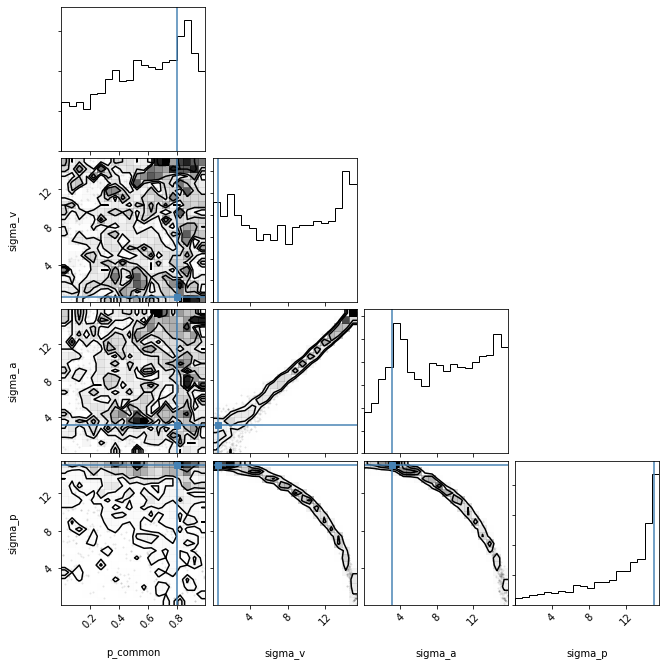

In [22]:
# Plotting corner plot
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = list(reasonable_param_range.keys())[:-1]
truths = list(params.values())[:-1]

fig = corner.corner(
    flat_samples , labels=labels, truths=truths
);

**2h. Compute the mean value of the sampled points in the parameter space and compare
its accuracy to that of the brute-force approach. Discuss the advantages and
disadvantages of the two methods.**

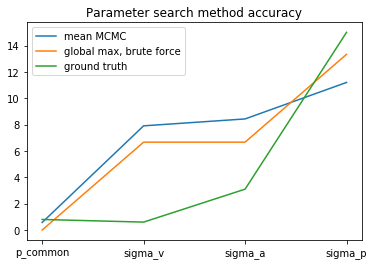

array([ 0.5719188 ,  1.23852906,  1.76191622, -2.1349265 ])

In [27]:
x = np.arange(4)
plt.xticks(x, list(params.keys()))

plt.plot(x, np.mean(flat_samples, axis=0), label='mean MCMC') 
plt.plot(x, global_ml, label='global max, brute force')
plt.plot(x, list(params.values())[:-1], label='ground truth')

plt.title('Parameter search method accuracy')
plt.legend()
plt.show()

np.mean(flat_samples, axis=0) - global_ml

**2i. Generate a new experimental data set using two "subjects", one with a = 9, and
the other with a = 2 (the other parameters should be pcommon = 0:3, v = 2:1,
p = 12 for both). Combine their data into a single dataset. How well does the
MCMC sampler deal with this new data? What implications does this have for
tting real experimental data?**

In [0]:
params_sub1 = {
    "p_common": 0.3,
    "sigma_v": 2.1,
    "sigma_a": 9,
    "sigma_p": 12,
    "mu_p": 0
}

params_sub2 = {
    "p_common": 0.3,
    "sigma_v": 2.1,
    "sigma_a": 2,
    "sigma_p": 12,
    "mu_p": 0
}

exp_data1 = make_button_presses(N, **params_sub1)
exp_data2 = make_button_presses(N, **params_sub2)

exp_data_both = exp_data1 + exp_data2


In [25]:
sampler2i = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[exp_data_both, reasonable_param_range])
state2i = sampler.run_mcmc(p0, 30) 
sampler2i.reset()
sampler2i.run_mcmc(state, 1000)

State([[ 0.67305619  5.13038995  2.09189338 13.85084137]
 [ 0.67574818  5.57496186  6.8690824  14.10703743]
 [ 0.58362668 10.23229812 10.24105994 11.29764428]
 [ 0.63285711  8.42517029  9.01870838 12.17334779]
 [ 0.57115235 10.37264805 10.669269   11.1031752 ]
 [ 0.72759583  2.81243303  5.46225159 14.70162128]
 [ 0.62371502 10.32089404 12.14364055  9.28183348]
 [ 0.58553611 10.24086557 10.32208784 11.06384713]
 [ 0.56167326 13.00330885 13.872498    7.15422925]
 [ 0.53586688 10.07330703 11.86860117 10.4063634 ]
 [ 0.72063751  5.76471406  5.94373419 14.13384509]
 [ 0.56879647  9.4020974  10.31412545 11.51963424]
 [ 0.53991546 12.70394924 11.91573224  6.51369814]
 [ 0.79504879  3.09944611  4.02349104 14.70493659]
 [ 0.57469986 14.39588717 14.68162172  4.89002237]
 [ 0.69115083  4.79423958  7.05660114 14.47702907]
 [ 0.58760732  9.8448705   9.34274594 11.79509665]
 [ 0.72136344 13.10246108 13.02542786  7.74337293]
 [ 0.69740704 13.55553771 12.98045632  6.74002881]
 [ 0.36810546  9.48362797

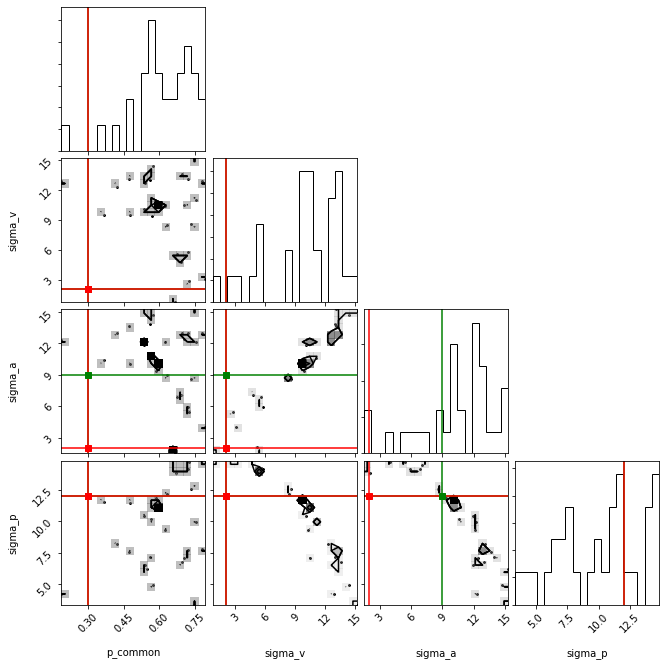

In [26]:
flat_samples2i = sampler2i.get_chain(discard=100, thin=15, flat=True)

def multitruth_corner(samples, labels, value1, value2):
  # Make the base corner plot
  figure = corner.corner(samples, labels=labels)

  # Extract the axes
  axes = np.array(figure.axes).reshape((ndim, ndim))

  # Loop over the diagonal
  for i in range(ndim):
      ax = axes[i, i]
      ax.axvline(value1[i], color="g")
      ax.axvline(value2[i], color="r")

  # Loop over the histograms
  for yi in range(ndim):
      for xi in range(yi):
          ax = axes[yi, xi]
          ax.axvline(value1[xi], color="g")
          ax.axvline(value2[xi], color="r")
          ax.axhline(value1[yi], color="g")
          ax.axhline(value2[yi], color="r")
          ax.plot(value1[xi], value1[yi], "sg")
          ax.plot(value2[xi], value2[yi], "sr")

multitruth_corner(flat_samples2i, labels, list(params_sub1.values())[:-1], list(params_sub2.values())[:-1])